# Entrenamiento y prueba de un modelo clasificador basado en árboles de decisión

Observando el dataset que manejamos, percibimos que tiene pocos datos y, para el problema que queremos resolver, necesitamos un clasificador binario dado que el *target* es una variable discreta que toma los valores "SI" o "NO". Para ello, podemos pensar en una primera aproximación a través de árboles de decisión, cuya interpretación es muy intuitiva y tienen alta explicabilidad. 

El dilema que encontramos aquí es que este tipo de modelos tienden a sobreajustar los datos de entrenamiento. Debido a la naturaleza del problema y a los escasos datos en general de los que partimos, quizás los resultados al evaluar el rendimiento a través de una división en *training* y *test* no sean concluyentes. Estudiaremos si podemos recurrir a validación cruzada y si esta técnica mejora la evaluación de resultados. 

Se ha elegido un árbol de decisión por encima de modelos más complejos como *Random Forest* debido a que tenemos pocos datos, y es un problema de clasificación bastante sencillo, con no muchas variables. Aún así, también probaremos con modelos algo más complejos como redes neuronales no muy densas. 

Una vez se haya entrenado el modelo, se pondrá en práctica con 4 instancias de datos cuyas etiquetas desconocemos, ya que son días que, a día de hoy (25 de julio de 2025), no se han desarrollado aún. La utilidad del modelo será poder predecir la niebla que habrá durante estos días en base a las previsiones de las que disponemos.

## Paquetes

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score 
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

## Importación de datos y tratamiento

Primero, descargamos los datos de los CSV's generados con las llamadas a la API de la AEMET.

In [18]:
semilla = 123
np.random.seed(semilla)
base_dir = os.path.dirname(os.path.abspath(os.getcwd()))

datos = pd.read_csv(os.path.join(base_dir, "data", "processed", "data.csv"), sep=";")
datos_sin_etiquetar = pd.read_csv(os.path.join(base_dir, "data", "processed", "data_sin_etiquetar.csv"), sep=";")

Una vez cargados, debemos convertir las variables cualitativas a *dummies* para asegurar un correcto entrenamiento y uso del modelo. Lo haremos con la función `get_dummies` de `pandas`.

Primero, extraemos las variable categóricas de los dataset:

In [19]:
categoricas = datos.select_dtypes(include= ["object", "category"]).columns
categoricas_sin_etiquetar = datos_sin_etiquetar.select_dtypes(include= ["object", "category"]).columns
categoricas

Index(['fecha', 'altonubes', 'nubosidad', 'lluvia', 'viento', 'SUBIR'], dtype='object')

No vamos a tener en cuenta las variables "fecha", dado que esta es el índice (clave primaria que identifica cada dato); ni "SUBIR", dado que es el target a predecir y no haría falta transformarlo. De hecho, la variable "fecha" podrá eliminarse por completo del dataset, dado que no influye a la hora de realizar las predicciones.

In [20]:
categoricas = categoricas.delete([0, 5])
datos.drop("fecha", axis=1, inplace=True)
categoricas

Index(['altonubes', 'nubosidad', 'lluvia', 'viento'], dtype='object')

De las "sin etiquetar", vamos a eliminar únicamente la fecha.

In [21]:
datos_sin_etiquetar.drop("fecha", axis=1, inplace=True)
categoricas_sin_etiquetar = categoricas_sin_etiquetar.delete(0)
categoricas_sin_etiquetar

Index(['altonubes', 'nubosidad', 'lluvia', 'viento'], dtype='object')

Transformamos a dummies y eliminamos las variables originales:

In [22]:
categoricas_dummies = pd.get_dummies(datos[categoricas], drop_first = True, dummy_na = True)
categoricas_sin_etiquetar_dummies = pd.get_dummies(datos_sin_etiquetar[categoricas_sin_etiquetar], drop_first = True, dummy_na = True)

datos.drop(categoricas, axis = 1, inplace = True)   # inplace para que se elimine sobre el dataset
datos_sin_etiquetar = datos_sin_etiquetar.reindex(columns=datos.drop(columns="SUBIR").columns, fill_value=0)

# Tras eliminar los atributos originales, concatenamos los nuevos atributos creados para las variables categóricas.
datos = pd.concat([datos, categoricas_dummies], axis = 1)
datos_sin_etiquetar = pd.concat([datos_sin_etiquetar, categoricas_sin_etiquetar_dummies], axis = 1)

# Mostramos cómo queda tras este proceso
datos.head()

,prec,tmin,tmax,velmedia,hrMedia,hrMax,hrMin,SUBIR,altonubes_mid,altonubes_nan,nubosidad_escasa,nubosidad_media,nubosidad_nan,lluvia_no,lluvia_posible,lluvia_nan,viento_fuerte,viento_moderado,viento_nan
0,0.0,11.9,20.4,1.4,99.0,100.0,61.0,NO,False,False,False,False,False,False,True,False,False,True,False
1,2.0,11.7,25.0,2.5,64.0,100.0,40.0,NO,False,True,False,False,True,False,False,True,False,False,True
2,23.8,13.7,26.6,5.6,54.0,94.0,34.0,SI,True,False,True,False,False,False,False,False,True,False,False
3,2.0,11.5,19.9,3.6,86.0,100.0,50.0,SI,False,True,False,False,False,False,False,False,False,True,False
4,0.0,11.4,18.2,1.4,95.0,100.0,80.0,NO,False,False,True,False,False,True,False,False,False,False,False


## Construcción del modelo

Una vez preparados los datos, vamos a proceder con el entrenamiento del modelo. Para ello, usaremos los datos etiquetados de los que disponemos, que conforman un conjunto extremadamente pequeño. Debido a esto, no conviene realizar un *train-test split* al uso, sino que optamos por una validación cruzada con *Leave-One-Out*. Esta es la mejor forma de lidiar con datasets pequeños, dado que cada instancia se usará una vez como test, y el resto como entrenamiento. Es una técnica costosa computacionalmente, pero ante la escasa cantidad de datos, no será un inconveniente.

Primero, separamos las *features* (variables predictoras del dataset) del *target* a predecir:

In [23]:
X = datos.drop(columns="SUBIR")
y = datos.SUBIR

Podemos comprobar que hay un cierto desbalance de clases en el dataset, dado que el target toma más a menudo el valor "NO". Esto puede hacer que la métrica *accuracy* pueda no ser la apropiada.

In [24]:
y.value_counts(normalize=True)

SUBIR
NO    0.625
SI    0.375
Name: proportion, dtype: float64

Procedemos ahora con la validación cruzada mediante *Leave One Out*. Además, crearemos cada modelo en cada iteración del LOO con los hiperparámetros óptimos al evaluarlo mediante un *grid* anidado dentro. La medida de evaluación elegida es, finalmente, la F1-score, debido al desbalanceo de clases que existe:

In [36]:
# Grid de parámetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9]
}

# Crear objeto asociado a la técnica del Leave One Out
loo = LeaveOneOut()

# Almacenar scores (f1) en test en la validación cruzada
scores_test = []
scores_training = []

# Almacenar otras métricas en test 
precisions = []
recalls = []
accuracies = []
accuracies_training = []

# Guardar valores reales y predichos para poder representar la matriz de confusión
y_true = []
y_pred = []

# Guardar los mejores parámetros de cada iteración
best_params_list = []

# Definimos el scorer que vamos a usar, basado en la f1-score, dado que al probar con accuracy,
# obtenemos un árbol subajustado.
scoring = make_scorer(f1_score, pos_label="SI", zero_division=0)

# Generar tantos pares de índices como filas tenga X
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
	# Definimos el grid dentro de la iteración
    grid = GridSearchCV(
        estimator= DecisionTreeClassifier(
            class_weight = "balanced",
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=semilla
		),
        param_grid= param_grid,
        scoring= scoring,
        cv = 5,   # validación cruzada de 5 folds dentro del entrenamiento
        refit = True,
        return_train_score= True
	)
    
	# Entrenamos el grid con los datos de train dentro de la iteración del LOO
    grid.fit(X_train, y_train)
    
	# Una vez entrenado el grid, podemos obtener el modelo que ha dado una mayor puntuación
    best_model = grid.best_estimator_
    f1_test = grid.best_score_
    pred_test = best_model.predict(X_test)
    pred_train = best_model.predict(X_train)
    
	# Guardamos las métricas de precisión y sensibilidad
    precisions.append(precision_score(y_test, pred_test, zero_division=0, pos_label="SI"))
    recalls.append(recall_score(y_test, pred_test, zero_division=0, pos_label="SI"))
    accuracies.append(accuracy_score(y_test, pred_test))
    accuracies_training.append(accuracy_score(y_train, pred_train))
    
	# Almacenar las f1-scores y los parametros
    scores_test.append(f1_test)
    scores_training.append(f1_score(y_train, pred_train, zero_division=0, pos_label="SI"))
    best_params_list.append(grid.best_params_)
    
	# Almacenar predicciones y valores reales
    y_pred.append(pred_test[0])
    y_true.append(y_test.values[0])


# Imprimimos los resultados finales
print(f"La F1-score promedio en training con LOO es: {np.mean(scores_training):.3f}")
print(f"La F1-score promedio en test con LOO es: {np.mean(scores_test):.3f}")
print(f"La exactitud promedio en test con LOO es: {np.mean(accuracies):.3f}")
print(f"La exactitud promedio en training con LOO es: {np.mean(accuracies_training):.3f}")
print(f"La precisión promedio en test con LOO es: {np.mean(precisions):.3f}")
print(f"La sensibilidad promedio en test con LOO es: {np.mean(recalls):.3f}")
frequent_params = max(set(tuple(p.items()) for p in best_params_list), key=best_params_list.count)
print(f"Hiperparámetros más frecuentes {frequent_params}")
best_params_final = dict(frequent_params)

La F1-score promedio en training con LOO es: 0.851
La F1-score promedio en test con LOO es: 0.510
La exactitud promedio en test con LOO es: 0.625
La exactitud promedio en training con LOO es: 0.904
La precisión promedio en test con LOO es: 0.125
La sensibilidad promedio en test con LOO es: 0.125
Hiperparámetros más frecuentes (('criterion', 'entropy'), ('max_depth', None))


Con este procedimiento, hemos encapsulado la búsqueda de los mejores parámetros para la creación del modelo, el entrenamiento del mismo y la evaluación de su rendimiento mediante *Leave One Out*.

Podemos ver que, aunque hemos intentado calibrar el modelo lo mejor posible, los resultados parecen apuntar a un problema grave de subajuste en test. El valor de la F1-score es algo deficiente (0.51), indicando un modelo cuyo funcionamiento en términos de precisión y sensibilidad no es muy bueno. La exactitud que obtenemos es superior a 0.5, pero aún así no es lo suficientemente alta como para indicar un modelo que funcione apropiadamente. Por último, la precisión y sensibilidad son muy bajas, lo cual quiere decir que hay muchos falsos positivos y falsos negativos. Esto quiere decir, en general, que el modelo no es capaz de identificar satisfactoriamente los suficientes verdaderos positivos, por lo que no nos resultaría útil para nuestro propósito.

Dado que los resultados en training son considerablemente mejores que los de test, podríamos hablar también de un **sobreajuste** en training, y un subajuste en test. El modelo ha sobreajustado, y memoriza los datos con los que ha sido entrenado.

El modelo final quedaría:

In [26]:
modelo_final = DecisionTreeClassifier(
	class_weight = "balanced",
	**best_params_final,
	min_samples_split = 2,
	min_samples_leaf = 1,
	random_state = semilla
)

# Lo entrenamos ahora con todos los datos de los que disponemos
modelo_final.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=123)

Representamos el árbol final gráficamente:

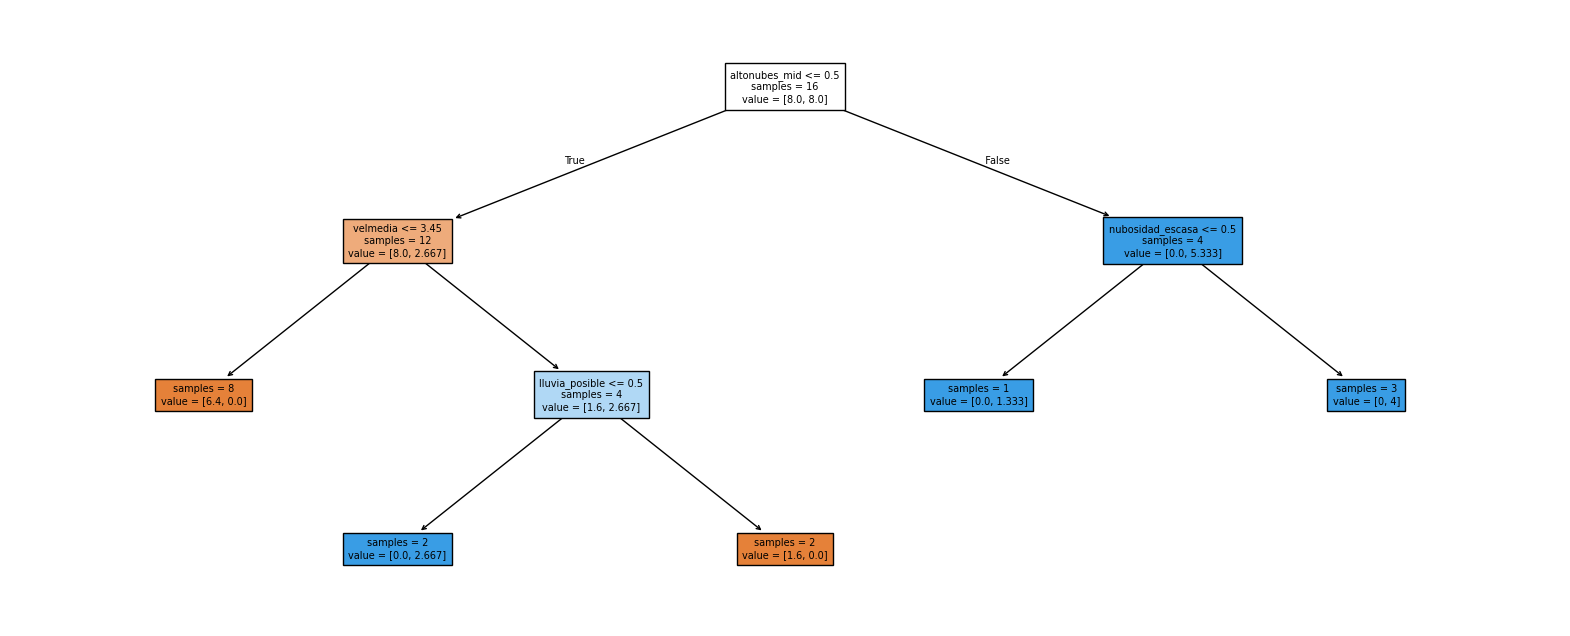

In [27]:
fig, ax = plt.subplots(figsize=(20, 8))
plot = plot_tree(
            decision_tree = modelo_final,
            feature_names = X.columns.tolist(),
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

Al representar gráficamente el árbol, podemos ver que, efectivamente, parece estar bastante subajustado (como evidenciaban los resultados de la evaluación numérica), aunque con tan pocos datos, no tendría sentido obtener un árbol más denso.

Podemos completar la obtención de métricas representando la matriz de confusión, donde veremos exactamente los aciertos y fallos de este modelo:

Matriz de confusión global: 


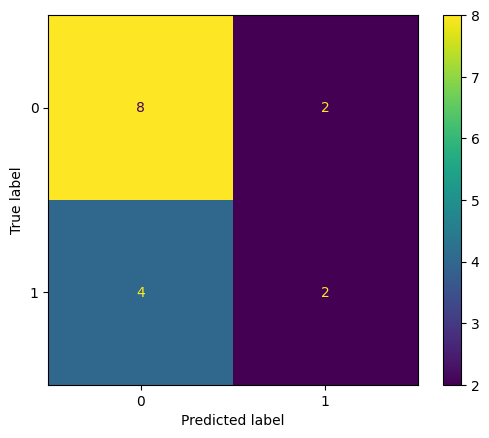

In [28]:
matriz = confusion_matrix(y_true, y_pred)
print("Matriz de confusión global: ")
disp = ConfusionMatrixDisplay(confusion_matrix=matriz)
disp.plot()

Podemos observar lo que habíamos adelantado al estudiar las medidas. El modelo parece tener un rendimiento decente al predecir los días que NO se debe subir por la niebla, pero no parece ser muy fiable prediciendo los días que SÍ se podría subir. Es decir, tiene un sesgo hacia la clase negativa, debido a que la mayoría de positivos reales los clasifica como negativos. No parece ser muy útil para indicar cuándo subir.

## Predicciones sobre datos nuevos y probabilidades

A pesar de que hemos visto que el modelo no es fiable a la hora de predecir si se puede subir o no a los lagos, no viene mal realizar la predicción sobre los datos reales de los cuales no tenemos etiquetas, a ver cómo clasifica a cada uno. En este caso, como aún no tenemos información de los días que vamos a tratar, usaremos el sentido común para ver si la predicción tiene sentido. Además, nos fijaremos en la probabilidad de la asignación a una clase u otra, de forma que si es cercana a 0.5, la predicción no será muy fiable (habrá sido más arbitraria, y no porque el modelo pueda asegurar la pertenencia de la instancia a esa clase).

Antes de realizar las predicciones, debemos coger el dataframe con los nuevos datos y reindexarlo para que tenga las mismas columnas que el que hemos usado para el entrenamiento. 

In [29]:
# Reindexar las columnas del nuevo dataset para que coincidan con las del modelo
X_nuevo_reindexado = datos_sin_etiquetar.reindex(columns=X.columns, fill_value=False)

Hecho esto, ya podemos obtener las probabilidades de las predicciones.

In [30]:
predicciones = modelo_final.predict_proba(X_nuevo_reindexado)
predicciones

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

Vemos que las probabilidades de predicción son 1 en todas, lo cual puede hacernos sospechar del funcionamiento del modelo. En teoría, esto implicaría sobreajuste, pero hemos estudiado que el modelo claramente no sobreajusta, sino que tiende más a subajustar. 

La explicación que hay detrás de este fenómeno puede ser que los nuevos datos se parecen demasiado a los que hemos empleado para entrenar el modelo, por lo que este de alguna manera "los conoce" y está muy seguro de la clase a la que pertenecen. Esto no implica que la predicción sea correcta ni que el modelo sea bueno con estos nuevos datos. De hecho, no podemos concluir si es bueno dado que, aunque los datos son nuevos, como se parecen a los de entrenamiento, no hay suficiente variedad para someter al modelo a pruebas en otros contextos.

Para ver con qué valor del target se corresponde cada columna, hacemos:

In [31]:
modelo_final.classes_

array(['NO', 'SI'], dtype=object)

Vemos que la primera es `SUBIR=NO`, y la segunda es la positiva. Por tanto, de los 4 datos, se predeciría que no se debe subir en el primero, y en los otros sí se podría subir. Si vemos los datos:

In [32]:
datos_sin_etiquetar

,prec,tmin,tmax,velmedia,hrMedia,hrMax,hrMin,altonubes_low,altonubes_nan,nubosidad_moderada,nubosidad_nan,lluvia_nan,viento_nan
0,0.0,14.0,23.0,0.0,77.5,90.0,60.0,True,False,False,False,False,False
1,0.0,11.0,25.0,10.0,80.0,100.0,60.0,True,False,True,False,False,False
2,85.0,12.0,26.0,10.0,0.0,100.0,50.0,False,False,True,False,False,False
3,90.0,15.0,25.0,10.0,0.0,90.0,55.0,False,False,True,False,False,True


Vemos que la predicción puede tener sentido, dado que en el primer día, hay nubosidad baja que sería abundante, por lo que habría niebla casi asegurada. En el segundo, por ejemplo, habría también nubes bajas, pero estas serían moderadas, lo cual puede hacer que el día sea propicio para subir. Algo similar ocurre con los otros dos.

En conclusión, aunque no podemos fiarnos exactamente de las predicciones de este modelo debido a los resultados desfavorables en la evaluación del rendimiento, podemos ver que, para los datos de previsiones del tiempo, que no suelen variar mucho, puede llegar a dar predicciones razonables. 